## 1. 문제 정의

- **분석목적**: 2년간(2016-06-01 ~ 2019-02-28)의 카드거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 **총 매출** 예측 
- **가설수립**
    - 1. 평일 점심시간과 퇴근 시간 이후(6시 이후) 매출이 높을 것이다
    - 2. 주말 및 공휴일에 매출이 높을 것이다
    - 3. 할부 개월 수가 높을수록 매출이 높을 것이다

## 2. 데이터 수집

- [dacon 9회 펀다 상점 매출 예측](https://dacon.io/competitions/official/140472/overview/description/)

#### 데이터 정보(column)
- store_id: 상점 고유 아이디
- card_id: 사용한 카드의 고유 아이디
- card_company: 비식별화된 카드 회사
- trasacted_date: 거래 날짜
- trasacted_time: 거래 시간(시:분)
- installment_term: 할부 개월 수
    (포인트 사용 시 (60개월+실제할부개월)을 할부 개월수에 기재한다)
- region: 상점의 지역
- type_of_business: 상점의 업종 
- amount: 거래액(단위는 원이 아니다)

In [1]:
train = pd.read_csv("funda_train.csv")
train.tail(2)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,기타 주점업,5857.142857


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


## 3. 데이터 처리

### 1. 결측치 확인

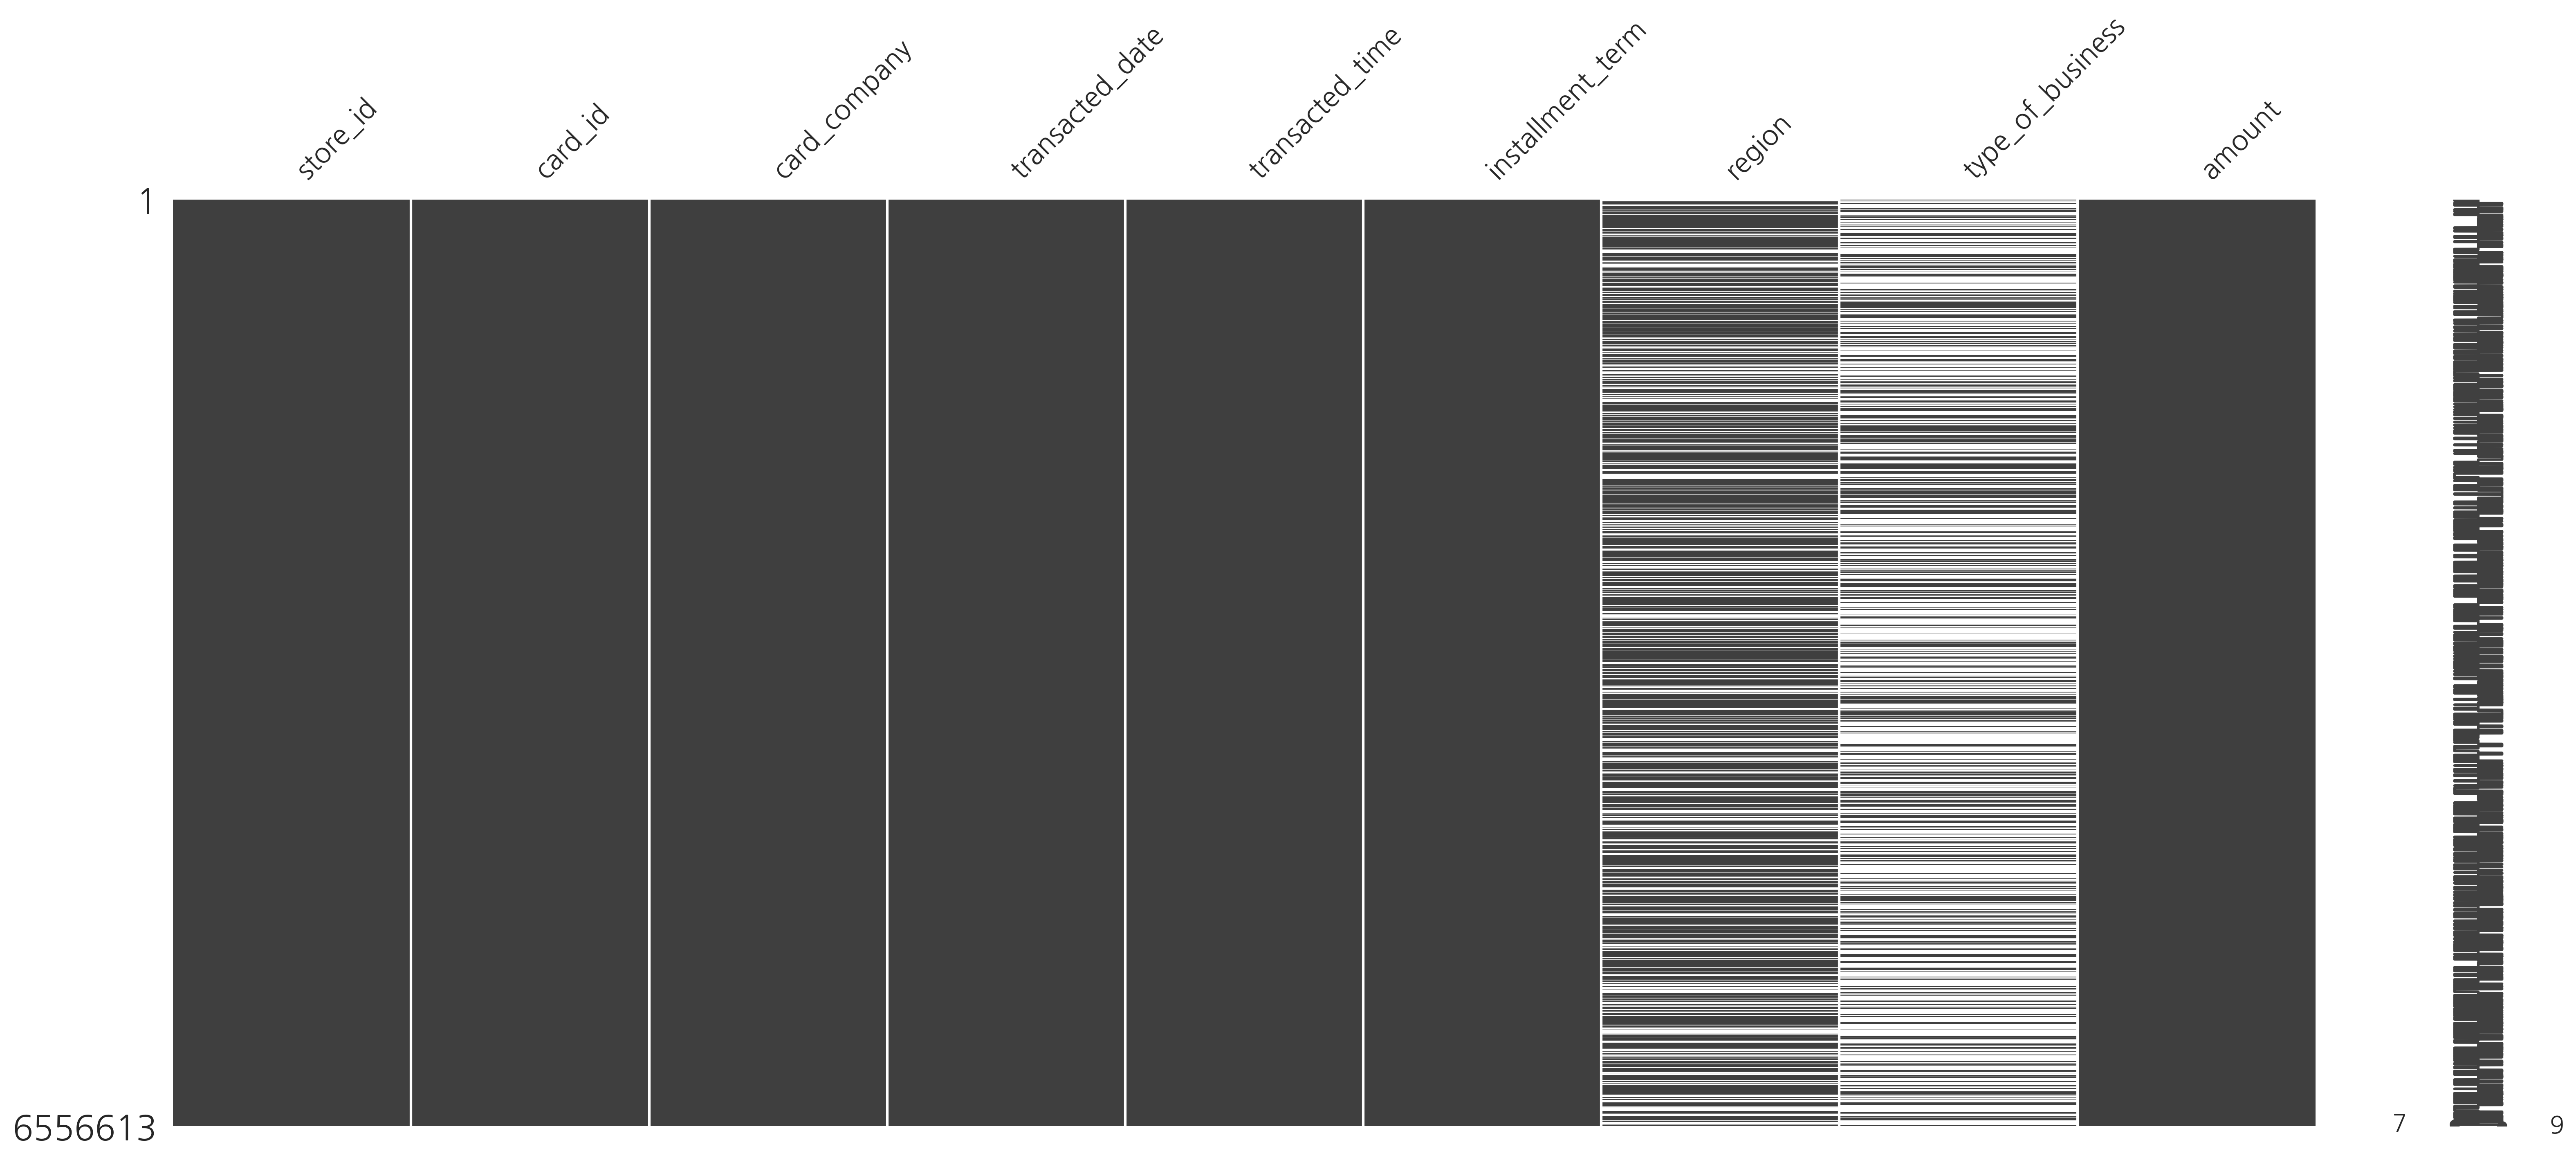

In [3]:
import missingno as msno

msno.matrix(train)
plt.show()

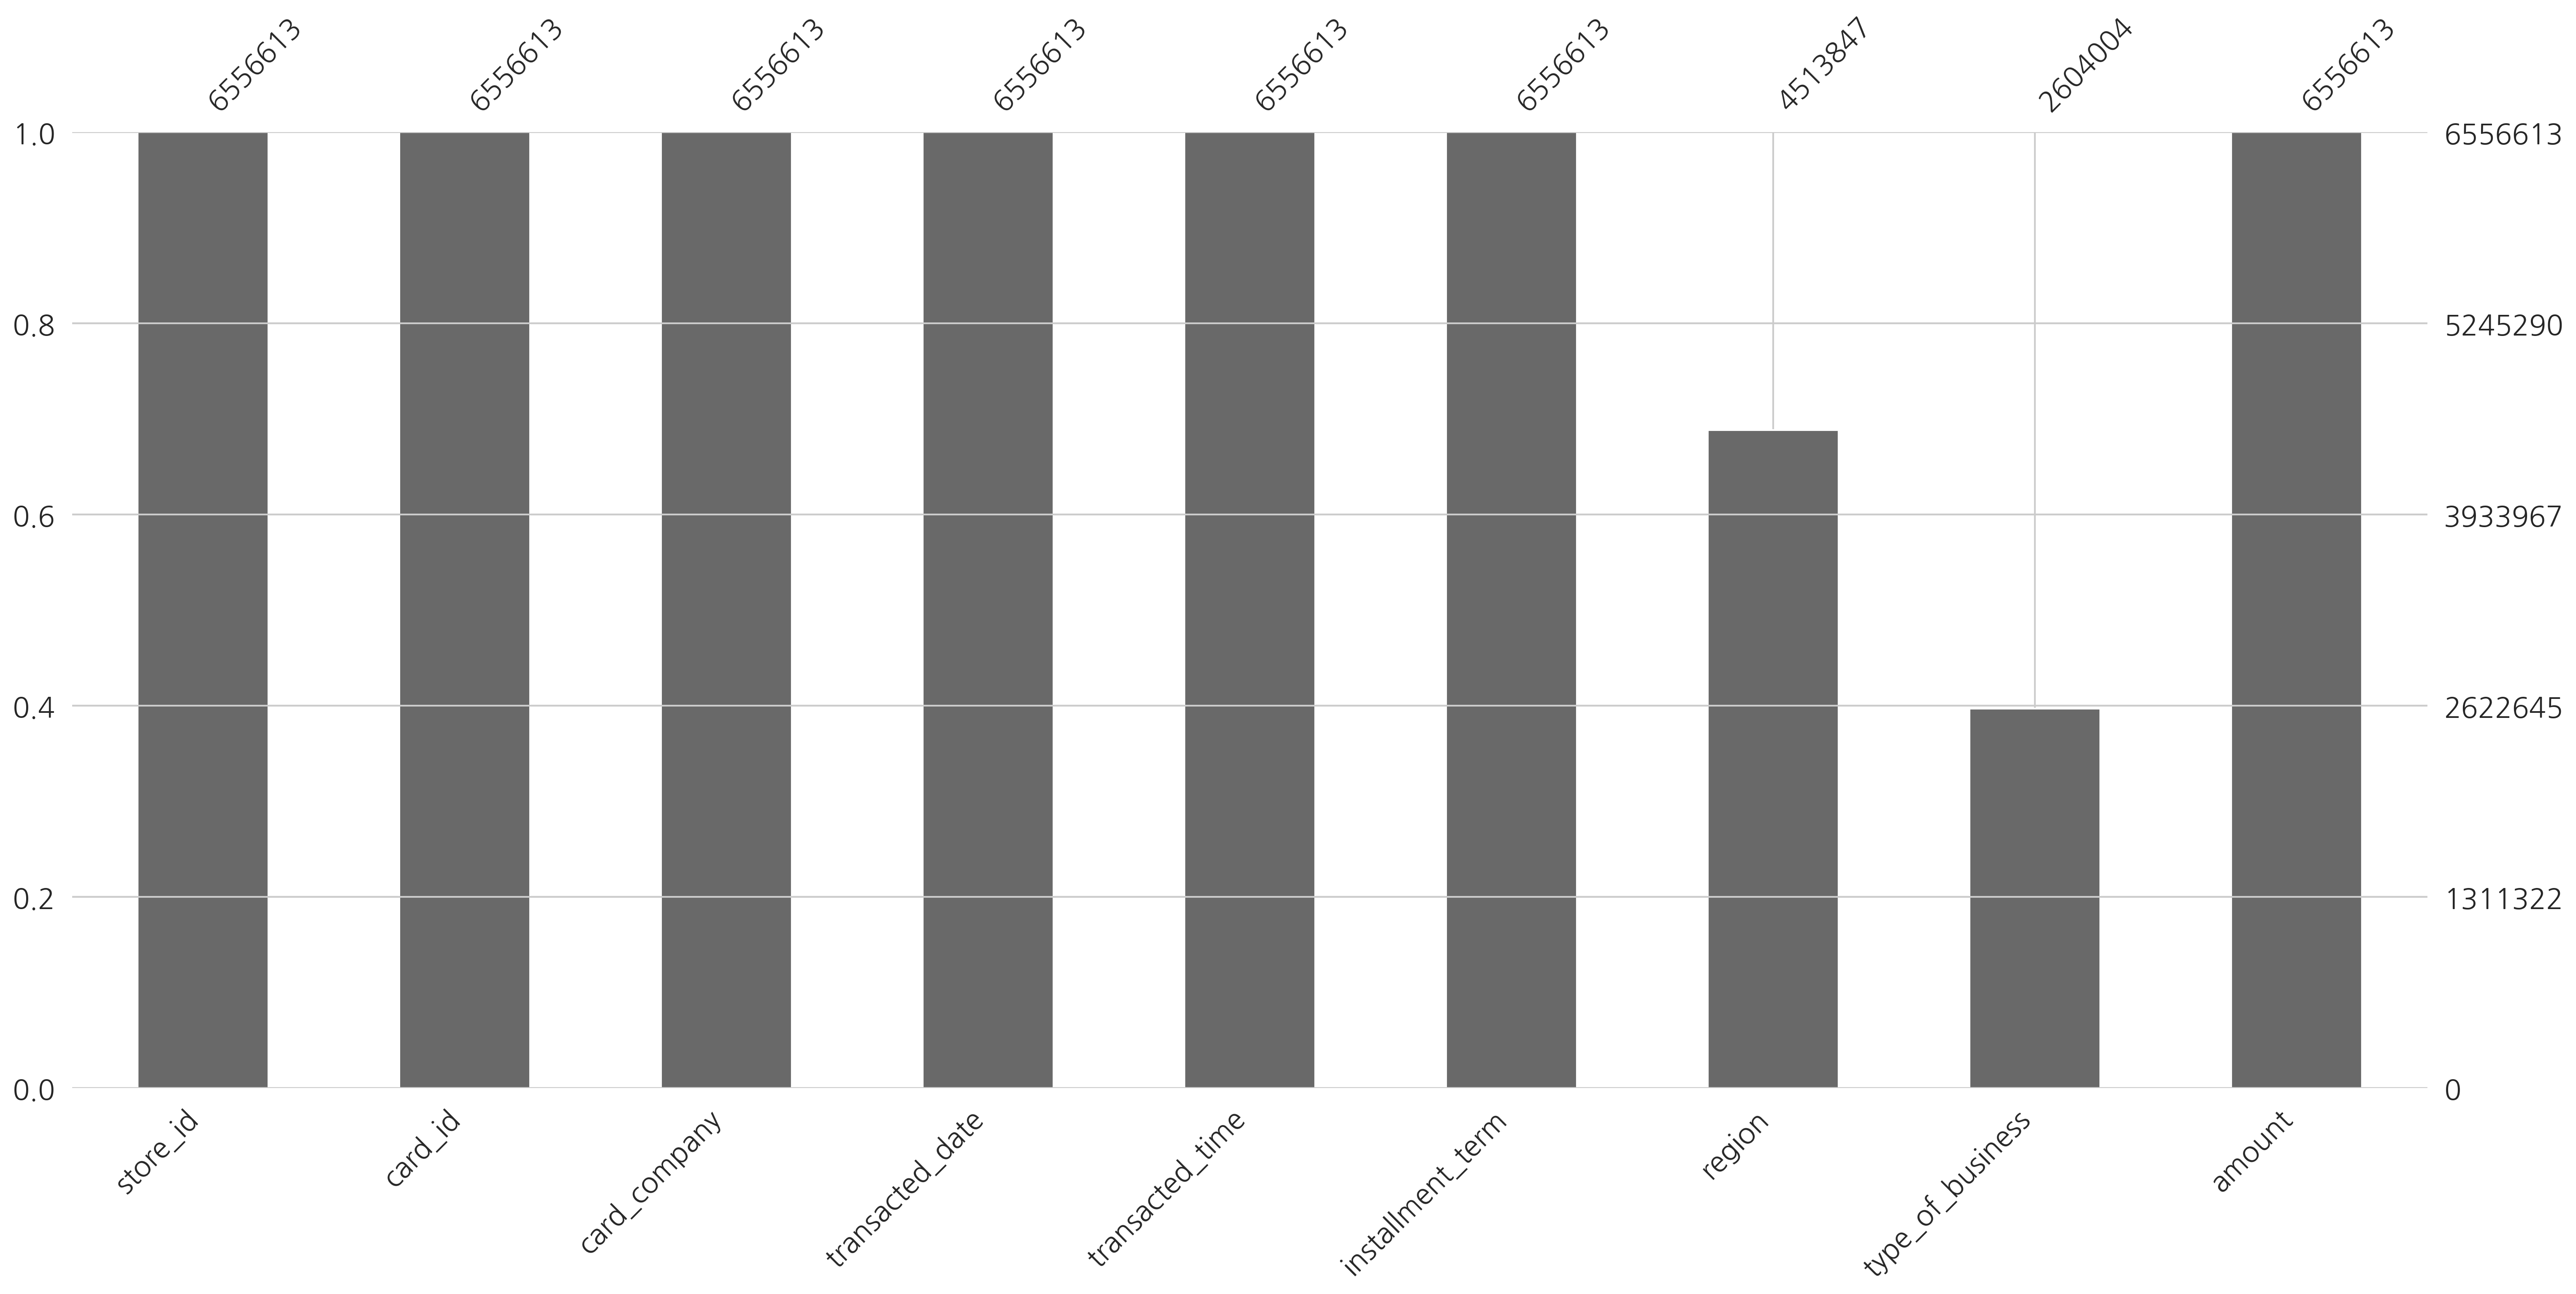

In [4]:
msno.bar(train)
plt.show()

In [5]:
train.drop(['type_of_business'], axis='columns', inplace=True)
train.tail(2)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,amount
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,571.428571
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,5857.142857


- region열은 카테고리 데이터 종류가 많아 결측치를 임의로 채우지 않았다
- type_of_business에 따라 매출이 달라질 것 같지만, 결측치가 약 60%이므로 삭제했다

### 2. 시계열 데이터 분해

In [6]:
import datetime

In [7]:
# 날짜, 시간 데이터를 연/월/일/시간/주 로 나누기 위해 datetime으로 데이터타입 변경
date_time = train['transacted_date']+' '+train['transacted_time']
train['transacted_dt'] = pd.to_datetime(date_time) 

train['year'] = train['transacted_dt'].dt.year
train['month'] = train['transacted_dt'].dt.month
train['day'] = train['transacted_dt'].dt.day
train['hour'] = train['transacted_dt'].dt.hour
train['week'] = train['transacted_dt'].dt.day_name()
train.tail(1)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,amount,transacted_dt,year,month,day,hour,week
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,5857.142857,2019-02-28 23:54:00,2019,2,28,23,Thursday


In [8]:
# 필요없는 열 삭제
train.drop(['transacted_time', 'transacted_dt'], axis='columns', inplace=True)
train.tail(1)

,store_id,card_id,card_company,transacted_date,installment_term,region,amount,year,month,day,hour,week
6556612,2136,4658616,c,2019-02-28,0,제주 제주시,5857.142857,2019,2,28,23,Thursday


### 3. 시계열 데이터-목표변수 시각화

In [9]:
train_year = pd.pivot_table(train, values='amount', index='week', columns='year',aggfunc=np.mean)
train_year

year,2016,2017,2018,2019
week,,,,
Friday,11199.826930,10228.002125,10688.304596,11211.074637
Monday,12183.434016,10906.862661,11387.177386,12272.924295
Saturday,9826.710294,9027.980045,9000.426017,9605.173215
Sunday,9019.434816,8135.910930,8035.632499,8426.363752
Thursday,11757.879172,10640.097060,10987.319624,11814.352377
Tuesday,12261.893786,11088.137497,11253.576317,11752.612555
Wednesday,12240.409092,10838.636570,10882.855125,11971.016828


In [10]:
train_month = pd.pivot_table(train, values='amount', index='week', columns='month',aggfunc=np.mean)
train_month

month,1,2,3,4,5,6,7,8,9,10,11,12
week,,,,,,,,,,,,
Friday,10916.640946,11089.378601,10750.753481,10613.615822,9776.802164,10280.807892,10570.003573,10303.964916,10662.448798,10292.310192,10634.256411,11411.389395
Monday,11858.957274,11834.371603,11559.702969,11428.399925,10728.552838,10607.444974,11428.169393,11214.083900,11029.604078,11414.441079,11720.620247,11671.017981
Saturday,9628.188148,9626.088024,9569.375562,9033.790620,8533.050456,8870.405753,9100.456013,8736.993213,8887.228073,9024.526026,9245.354333,9826.274679
Sunday,8475.541252,8797.387772,8541.996056,8221.243772,7715.202385,7927.812755,8067.243005,8027.686264,8019.265169,8177.979482,8490.273448,8617.523648
Thursday,11472.443725,11382.463507,11154.064543,10545.474631,10416.959684,11046.224542,10716.692007,10897.944997,10864.704180,10717.160713,10832.675646,12134.816401
Tuesday,12045.297865,12287.200427,11592.571330,10971.623537,10458.122449,11001.613042,11273.645011,11120.404163,11282.885696,11259.455859,11633.012373,11602.110785
Wednesday,11931.709287,11820.455233,10978.663240,10774.116744,10737.709731,10935.849035,10904.852801,10759.952625,10435.824230,11038.125236,11281.709425,12148.417370


In [11]:
train_day = pd.pivot_table(train, values='amount', index='week', columns='day',aggfunc=np.mean)
train_day

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
week,,,,,,,,,,,,,,,,,,,,,
Friday,10969.757329,11061.904493,11001.809967,10650.731425,10235.738086,9661.996354,9998.195730,10346.610634,9958.839827,10002.039241,...,10124.044234,10926.642562,10716.674629,11088.384186,12052.064831,10955.594889,12837.776920,12171.677828,12354.125600,12055.881943
Monday,11002.527547,12016.504138,12245.988017,10775.502711,11951.827306,11562.043319,10746.227977,11305.791787,10361.450571,10480.207098,...,10939.103878,11263.817518,10743.792244,11377.486105,12607.315526,12232.969506,13673.047484,13232.028393,12373.118607,11949.173967
Saturday,9453.094937,9275.924259,9531.851442,9642.408783,9117.488329,9380.183193,9048.525314,9172.811383,9279.654519,9394.354389,...,8846.729809,8818.658236,9221.366466,9457.769399,8957.695768,9072.470899,8785.904620,9159.824424,9410.370976,9925.977200
Sunday,8102.877407,8402.907690,8414.425070,8726.191668,8930.382491,8383.315347,8306.820372,8112.067771,8101.516476,8209.390648,...,8171.340496,7867.554053,7912.548436,8564.198693,8749.195149,8347.497253,8169.444121,8132.169756,8049.696045,8446.254935
Thursday,11410.986960,11519.122345,10813.164671,10502.171861,10283.688962,11202.674630,10952.320286,11080.000581,10408.644484,10312.440305,...,10504.737490,10865.565131,10946.266407,11749.005099,11449.394805,12580.968935,12834.853777,12554.816989,13058.666159,12410.859312
Tuesday,10157.266190,11377.437130,10712.934456,11566.178715,10970.414501,11356.702648,11776.048011,10755.287336,10545.947026,11084.923907,...,9786.468657,10829.800627,11049.081278,10636.285052,13148.223576,13463.486339,13483.458877,13363.188702,13448.124534,13063.789877
Wednesday,11693.004172,11862.958679,10166.924613,10630.991613,10893.198076,9871.782372,11108.123527,11039.198563,10725.138662,11244.377714,...,10750.278288,10805.720399,10677.238351,11633.994793,11890.630483,12620.394785,13241.987358,13416.685990,12819.706175,12730.748130


In [12]:
train_hour = pd.pivot_table(train, values='amount', index='week', columns='hour',aggfunc=np.mean)
train_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
week,,,,,,,,,,,,,,,,,,,,,
Friday,9910.431969,11283.988115,12852.303987,13462.044896,11435.165277,10163.296024,8234.802992,12151.881255,19124.020721,19720.199829,...,12771.646321,14877.232753,14268.078570,13313.098451,10620.312040,9358.497696,9675.096015,9295.946070,8351.680999,8243.388680
Monday,7028.435991,7685.894811,8443.687040,9937.739050,10135.277870,9548.742731,9126.777727,15989.022824,17345.719563,19336.875117,...,13778.694770,15572.215086,15272.980177,14413.396898,11597.882181,10487.183171,10706.997668,10075.786568,9288.144996,9213.297011
Saturday,8812.443378,9904.468655,11246.481827,12582.881466,11632.714379,11162.426875,8740.455124,10282.890308,11490.112367,12572.060989,...,10028.026347,10518.505469,10663.356382,9742.380016,8588.231762,8150.690041,8349.762484,7758.266492,7110.579130,7192.682274
Sunday,7710.956779,8314.390076,9322.623222,10598.002102,11111.219117,10923.989672,8658.713930,9937.296354,9543.797363,8663.647733,...,9087.550596,9533.648844,9881.903317,9081.007195,7967.080974,7600.524513,7467.892059,6672.447650,6309.084885,6656.881791
Thursday,9834.604407,11098.959479,12863.752134,13686.730437,11660.295118,10055.907336,8131.477405,12010.904459,15074.200762,18799.672028,...,13235.924210,14749.631233,14484.444214,13364.505661,10701.568218,9736.964915,10457.285381,9886.559622,9224.489607,9178.752154
Tuesday,9971.339648,11453.784916,13352.226834,14074.168218,11765.545455,11050.435203,10404.690311,14469.235416,16746.728918,20602.953393,...,13518.096644,15402.124602,14874.373464,14066.999185,11274.658988,10100.359554,10544.426996,9939.648980,9272.737829,9008.691412
Wednesday,9902.351382,11040.897242,13016.606071,13471.060152,11714.171282,9635.248042,7858.631708,12600.238207,14537.476732,19459.906642,...,13728.192074,15015.055425,14784.309687,13307.570096,10798.572427,9842.823721,10295.781108,10010.143933,9112.473731,9270.797199


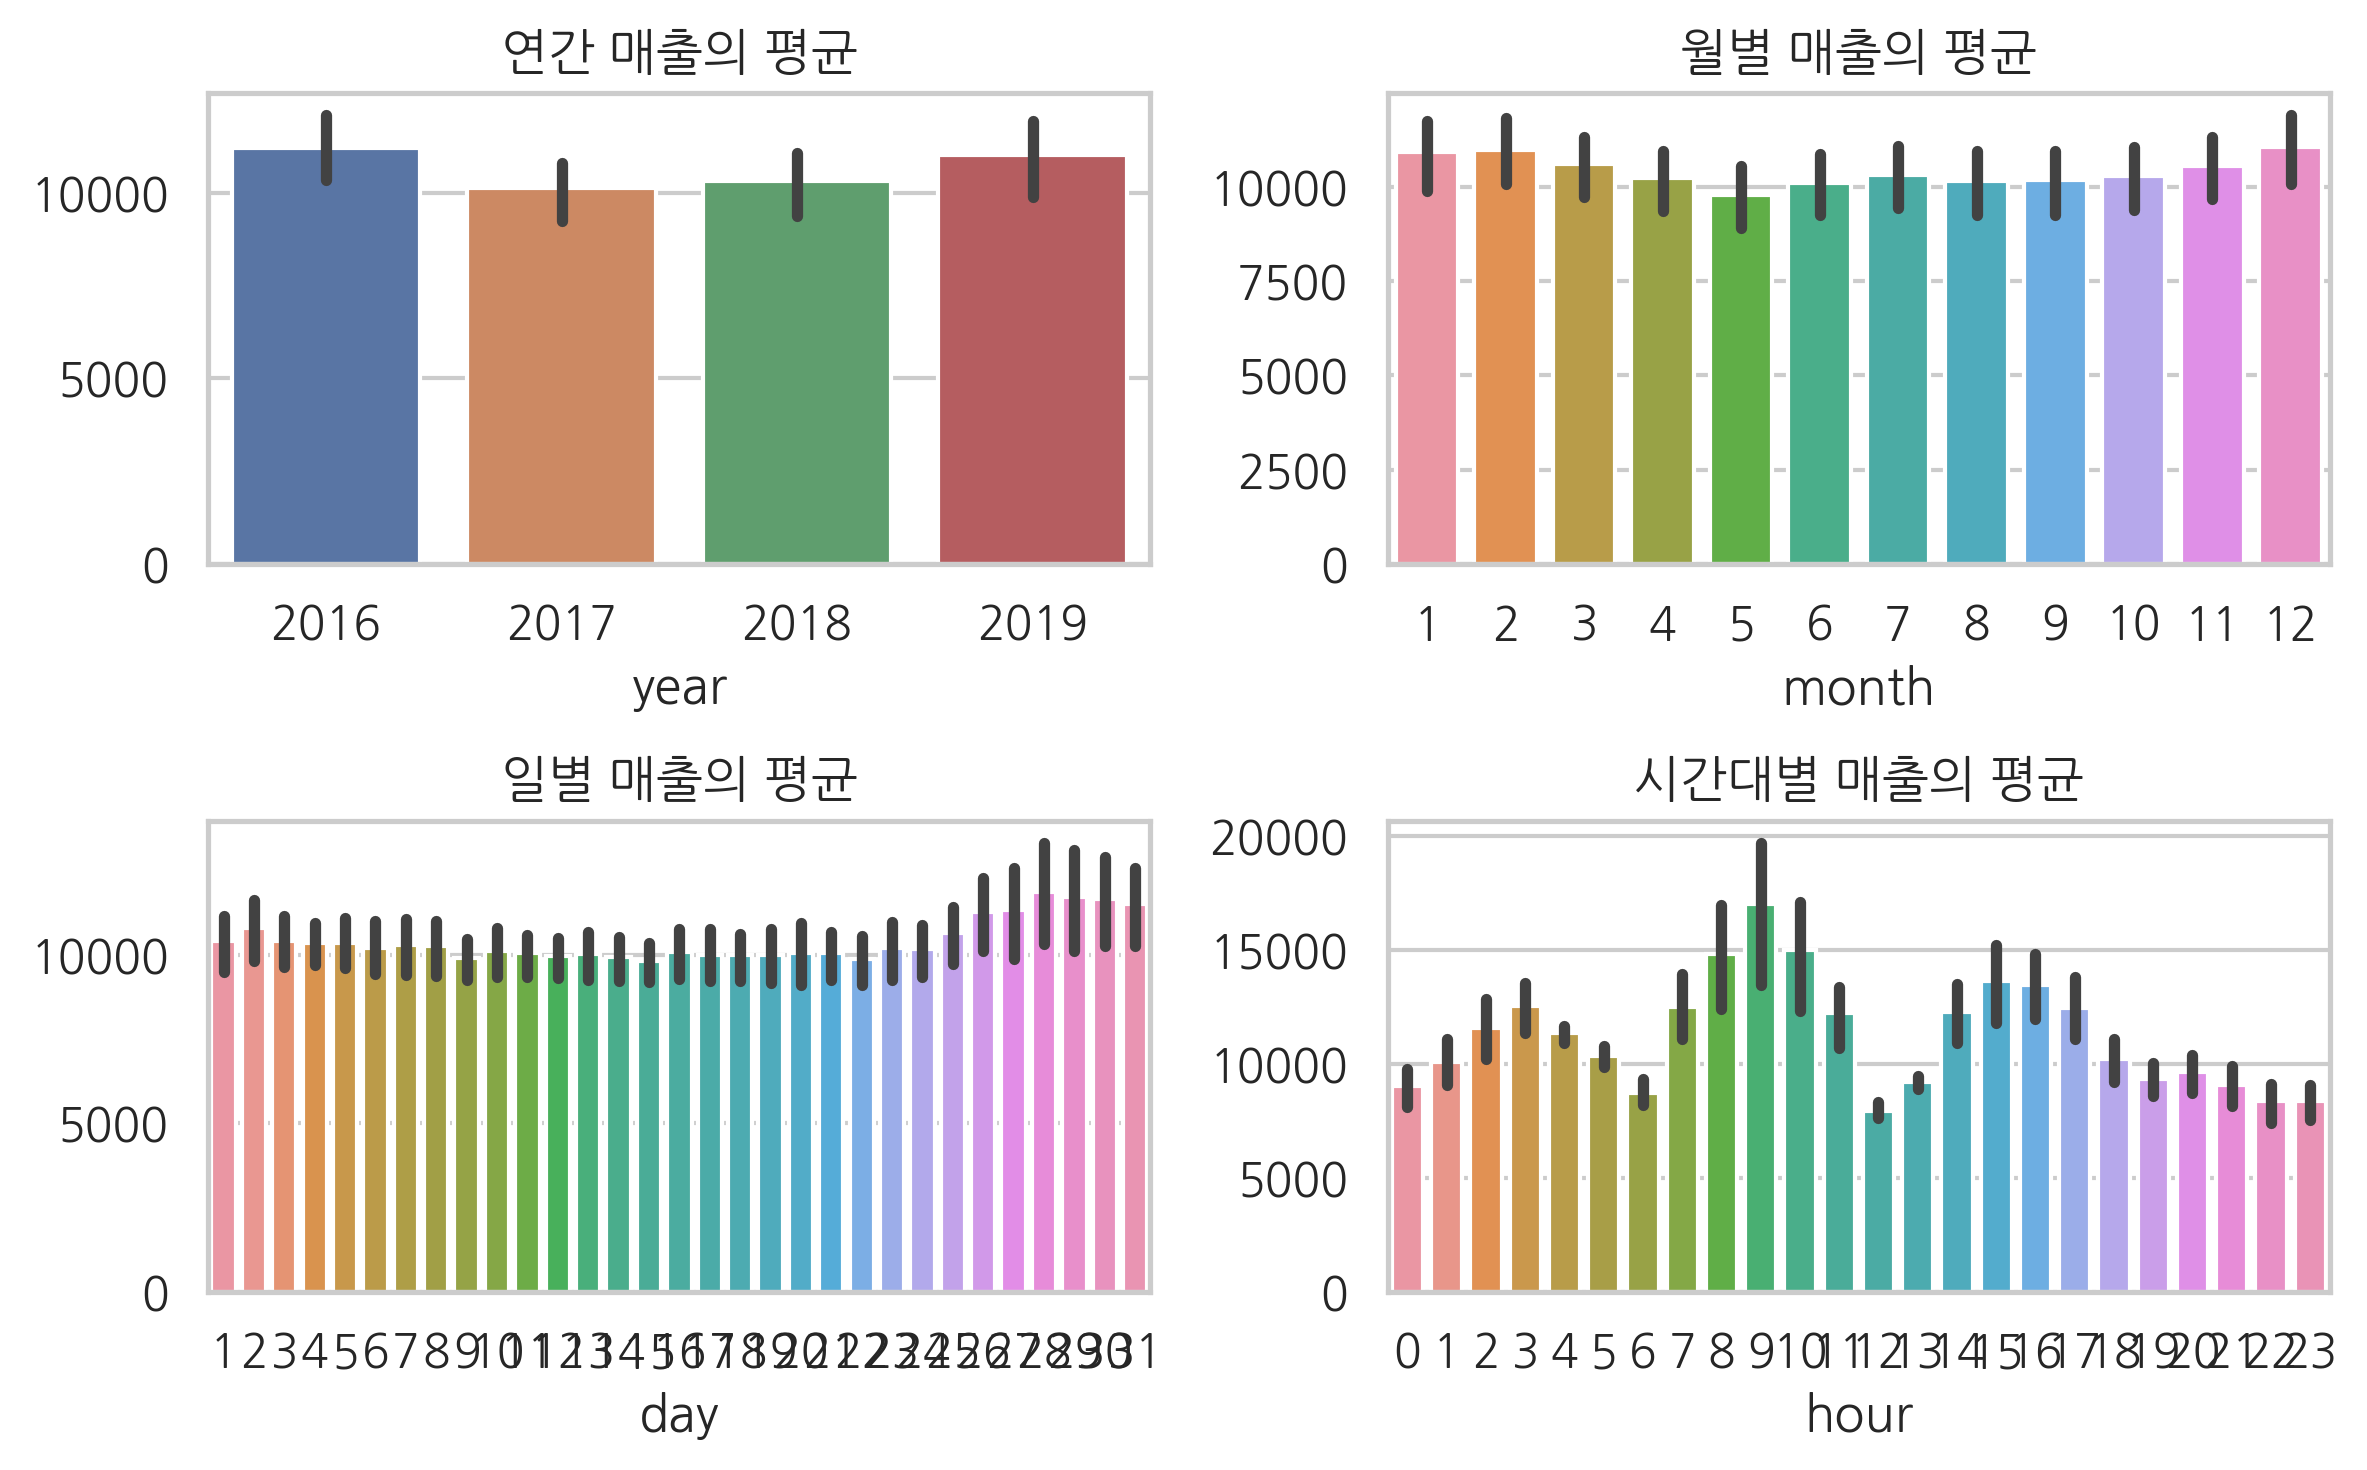

In [13]:
plt.subplot(221)
sns.barplot(data=train_year)
plt.title('연간 매출의 평균')

plt.subplot(222)
sns.barplot(data=train_month)
plt.title('월별 매출의 평균')

plt.subplot(223)
sns.barplot(data=train_day)
plt.title('일별 매출의 평균')

plt.subplot(224)
sns.barplot(data=train_hour)
plt.title('시간대별 매출의 평균')


plt.tight_layout()

- 연별, 월별과 매출은 크게 상관없다
- 일별 매출도 크게 상관 없지만 월말 매출 평균이 높은것으로 보아 월급일 후에 소비를 더 한 것 같다
- 새벽 시간대에 왜 높은지 모르겠다
- 출근시간대에 매출 최고점이 나타났고, 퇴근 시간 후에는 생각보다 매출이 낮았다
- 따라서 **가설 1. 평일 출근시간과 퇴근 시간 이후(6시 이후) 매출이 높을 것이다**는 평일 출근시간대에는 매출이 높지만 퇴근시간 이후에는 크게 높지않기 때문에 50% 사실이다

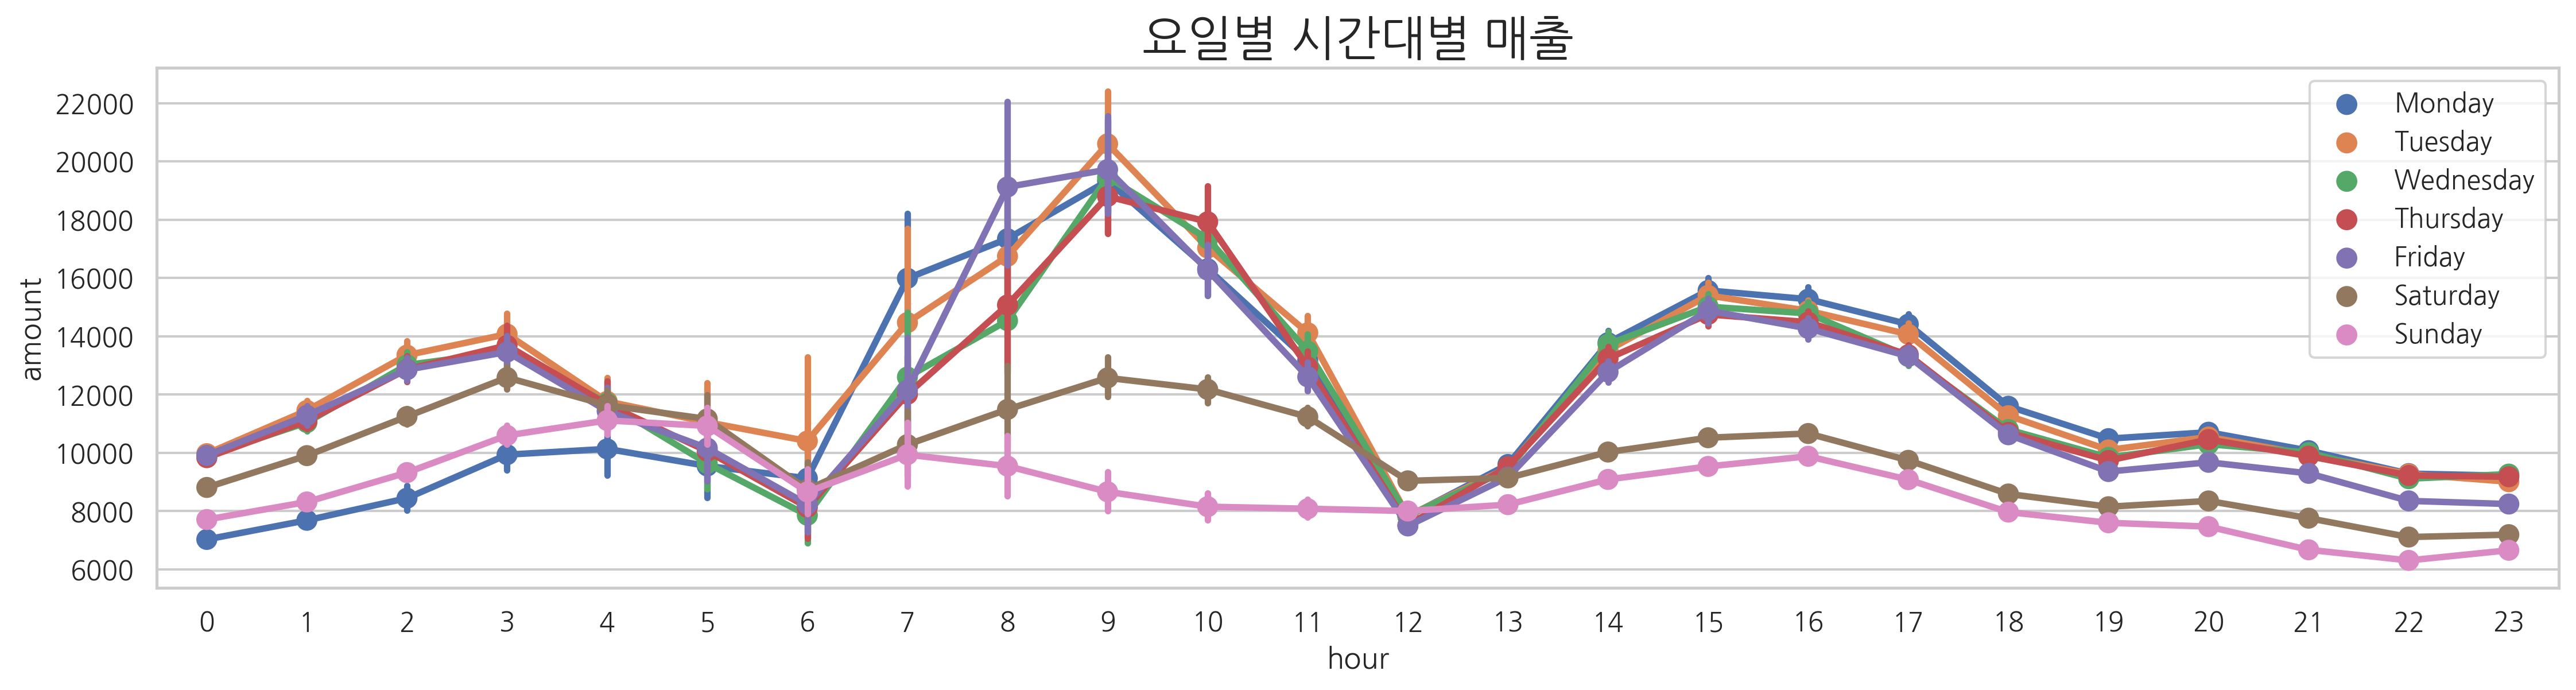

In [14]:
plt.figure(figsize=(18, 4))
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.pointplot(data=train, x='hour', y='amount', hue='week', hue_order=week_order)
plt.title('요일별 시간대별 매출', fontsize=20)
plt.legend()
plt.show()

In [15]:
week_amount = train.groupby('week').mean()[['amount']].sort_values(by="amount", ascending=False)
week_amount

,amount
week,
Tuesday,11383.442571
Monday,11377.697842
Wednesday,11156.399942
Thursday,11031.212360
Friday,10622.282412
Saturday,9177.771747
Sunday,8249.524301


#### 요일별 평균 매출
: 화 > 월 > 수 > 목 > 금 > 토 > 일

- **가설 2. 주말 및 공휴일에 매출이 높을 것이다**는 완전히 사실이 아니다

### 4. 변수별 상관관계 파악

In [16]:
train.corr()

,store_id,card_id,installment_term,amount,year,month,day,hour
store_id,1.000000,0.969906,-0.014859,-0.039063,0.026252,-0.002663,0.001312,0.011602
card_id,0.969906,1.000000,-0.013424,-0.038116,0.025326,-0.002727,0.001013,0.011438
installment_term,-0.014859,-0.013424,1.000000,0.212325,-0.004353,0.004589,0.003397,-0.002712
amount,-0.039063,-0.038116,0.212325,1.000000,-0.003955,-0.001678,0.010103,-0.014459
year,0.026252,0.025326,-0.004353,-0.003955,1.000000,-0.381218,-0.007931,-0.003417
month,-0.002663,-0.002727,0.004589,-0.001678,-0.381218,1.000000,0.009546,-0.001859
day,0.001312,0.001013,0.003397,0.010103,-0.007931,0.009546,1.000000,0.003987
hour,0.011602,0.011438,-0.002712,-0.014459,-0.003417,-0.001859,0.003987,1.000000


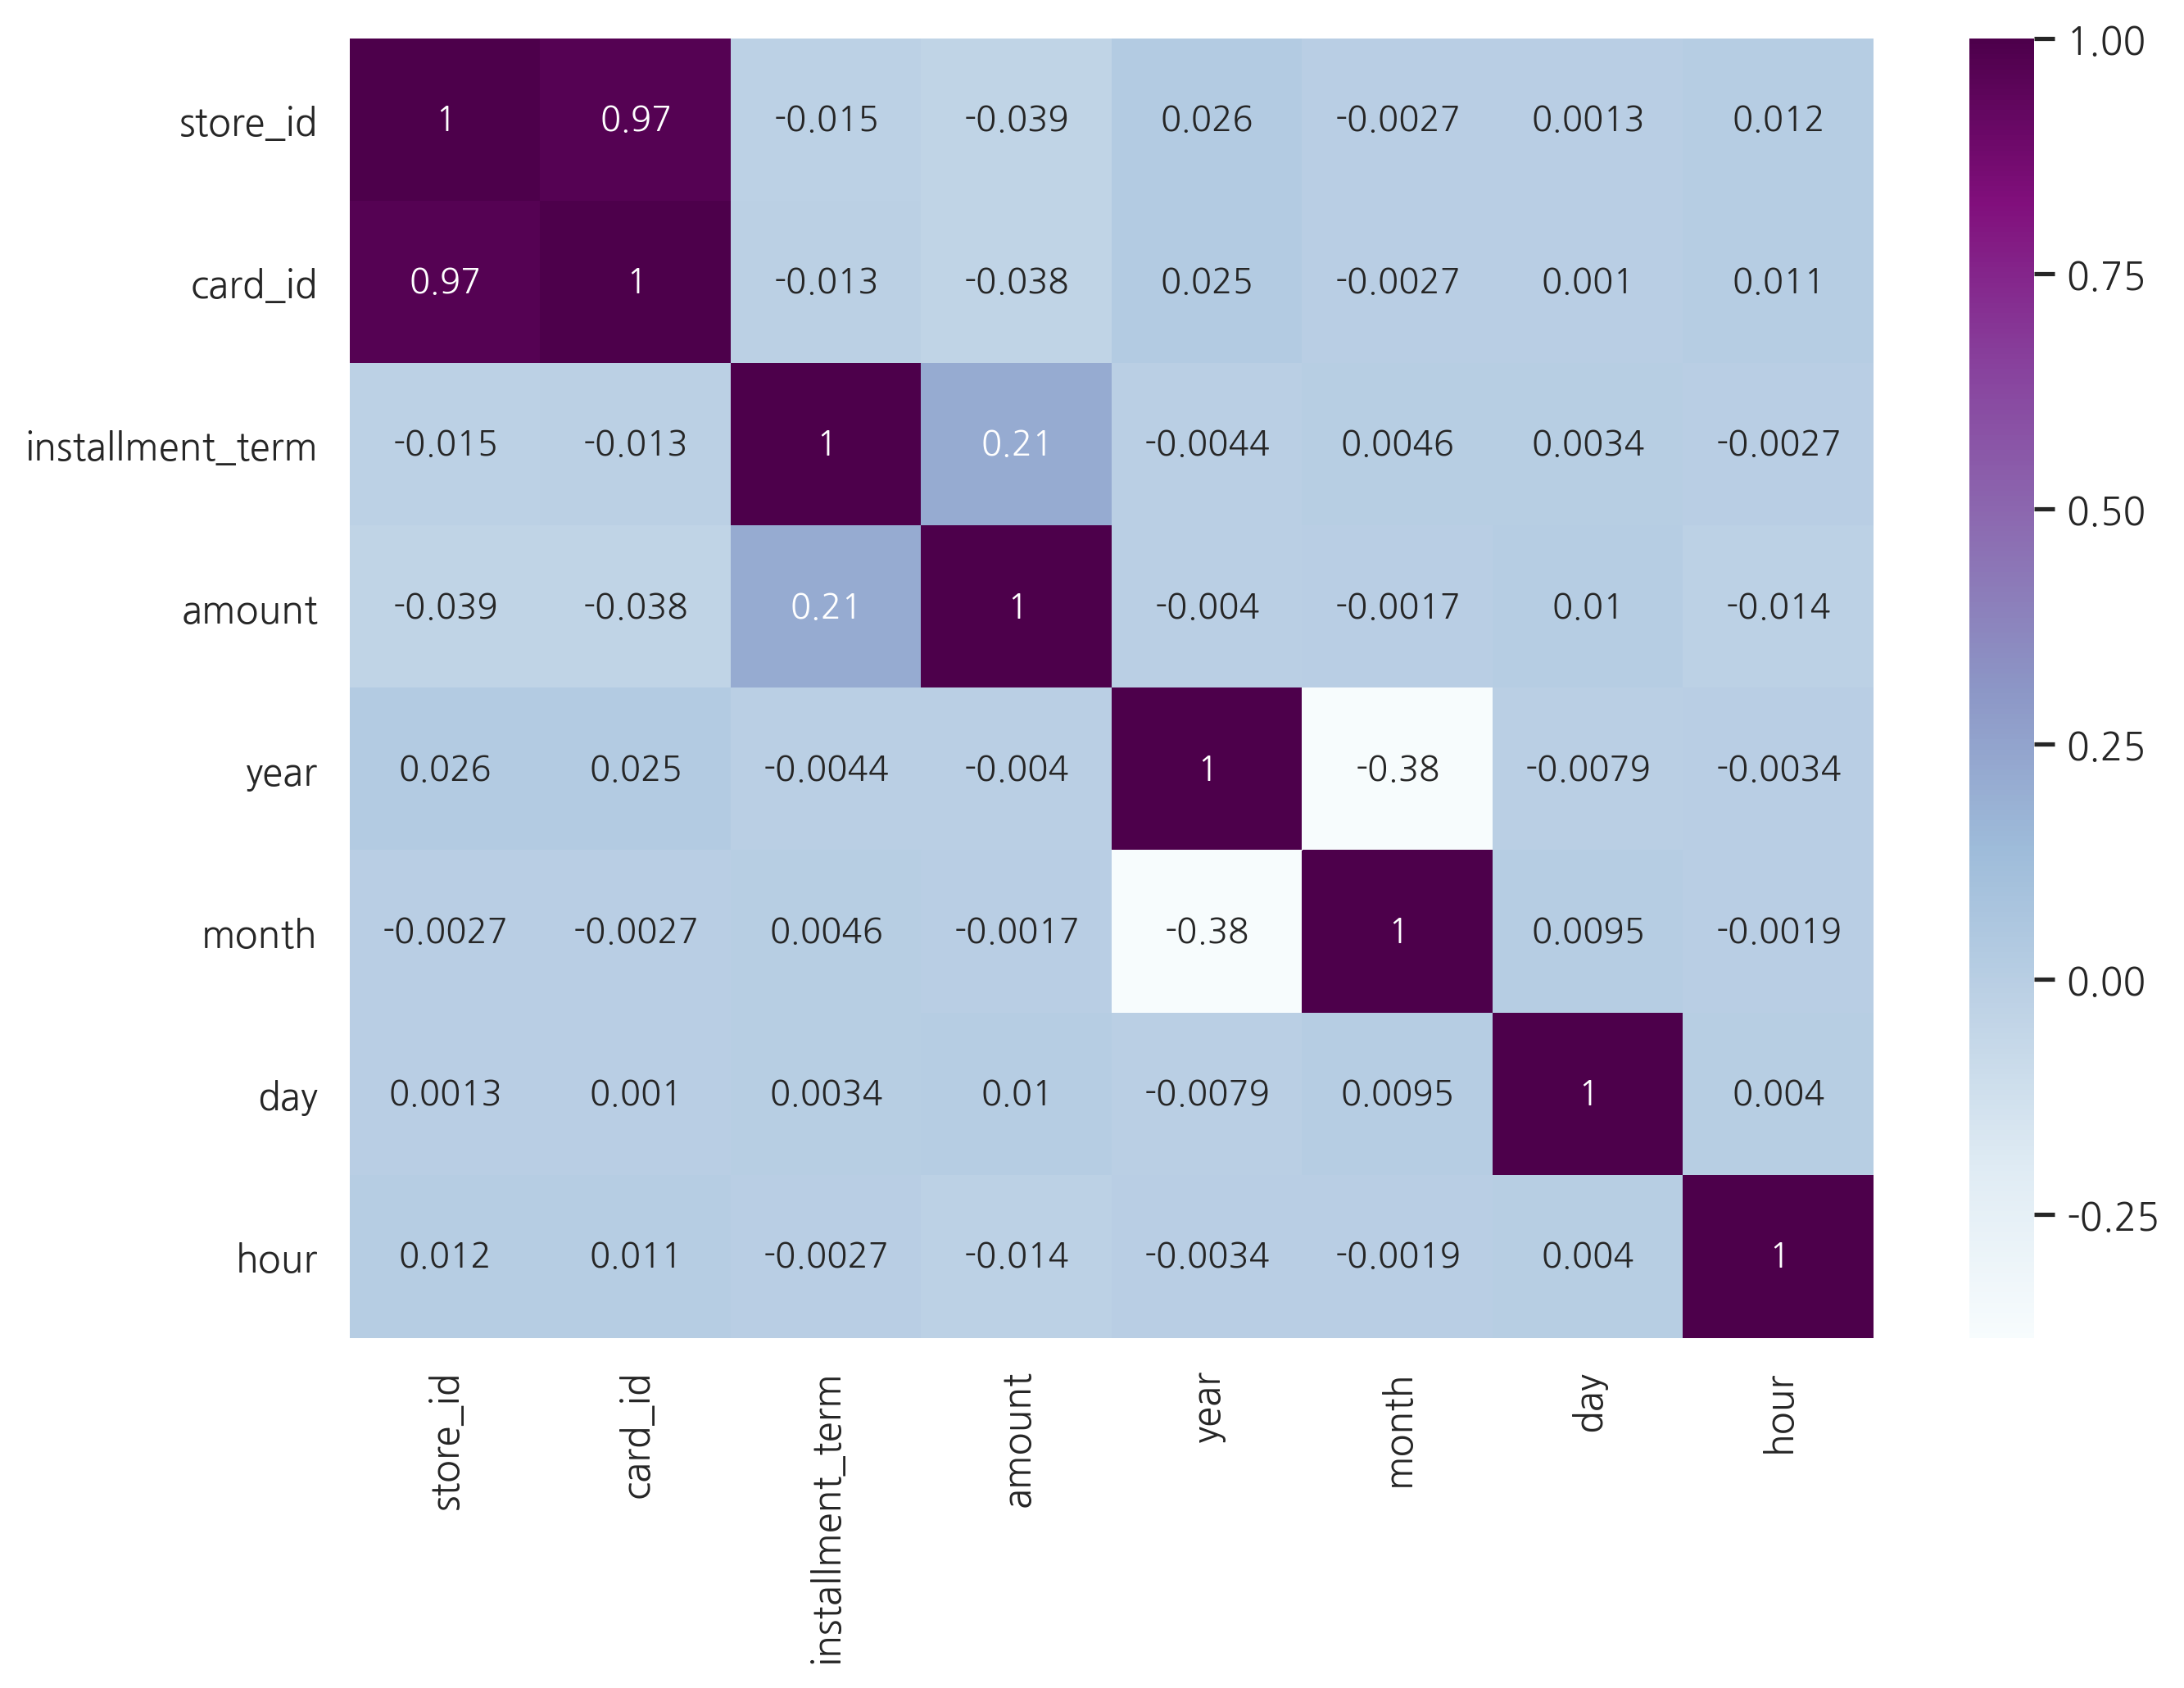

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(train.corr(), cmap='BuPu', annot=True)

### 5. 새로운 변수 생성
- real_installment
- royal_customer
- average_revisit
- 

#### real_installment
- installment_term이 60 이상인 데이터는 포인트를 사용한 결제 건이라서 실제 할부개월수와 차이가 있다
- 실제 할부개월수를 구하기 위해 real_installment 열을 추가했다

In [18]:
train['real_installment'] = train['installment_term'].apply(lambda x: x - 60 if x >= 60 else x)
train.tail(1)

,store_id,card_id,card_company,transacted_date,installment_term,region,amount,year,month,day,hour,week,real_installment
6556612,2136,4658616,c,2019-02-28,0,제주 제주시,5857.142857,2019,2,28,23,Thursday,0


#### royal_customer
- installment_term이 60 이상인 데이터는 포인트를 사용한 사람으로 단골일 것이다
- 이들을 royal_customer로 분류하여 royal_customer 열을 추가했다

In [19]:
train['royal_customer'] = train['installment_term'].apply(lambda x: 1 if x >= 60 else 0)
train.tail(2)

,store_id,card_id,card_company,transacted_date,installment_term,region,amount,year,month,day,hour,week,real_installment,royal_customer
6556611,2136,4663856,d,2019-02-28,0,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0
6556612,2136,4658616,c,2019-02-28,0,제주 제주시,5857.142857,2019,2,28,23,Thursday,0,0


In [20]:
train.drop(['installment_term'], axis='columns', inplace=True)
train.tail(2)

,store_id,card_id,card_company,transacted_date,region,amount,year,month,day,hour,week,real_installment,royal_customer
6556611,2136,4663856,d,2019-02-28,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0
6556612,2136,4658616,c,2019-02-28,제주 제주시,5857.142857,2019,2,28,23,Thursday,0,0


#### average_visit

In [21]:
# 스토어, 카드별 방문날짜의 횟수를 더해 재방문 일수로 지정
train_visitday = train.groupby(['store_id', 'card_id']).count()[['transacted_date']]
train_visitday

transacted_date
store_id card_id                 
0        0                      5
         1                      4
         2                      3
         3                      3
         4                      5
...                           ...
2136     4663852                1
         4663853                1
         4663854                1
         4663855                3
         4663856                1

[4067932 rows x 1 columns]

In [22]:
train_revisit = pd.merge(train, train_visitday, on=['store_id', 'card_id'])
train_revisit = train_revisit.rename(columns={'transacted_date_y': 'revisit'})
train_revisit.tail(2)

,store_id,card_id,card_company,transacted_date_x,region,amount,year,month,day,hour,week,real_installment,royal_customer,revisit
6556611,2136,4663855,d,2019-02-28,제주 제주시,4142.857143,2019,2,28,23,Thursday,0,0,3
6556612,2136,4663856,d,2019-02-28,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0,1


In [23]:
# 스토어별 revisit 횟수를 모두 더한 뒤, 스토어별 고객 수로 나눔
train_reviavg = pd.merge(train_revisit, train_revisit.groupby(['store_id']).sum()[['revisit']], on=['store_id'])
train_reviavg = train_reviavg.rename(columns={'revisit_x': 'revisit', 'revisit_y':'total_revisit'})
train_reviavg.tail(2)

,store_id,card_id,card_company,transacted_date_x,region,amount,year,month,day,hour,week,real_installment,royal_customer,revisit,total_revisit
6556611,2136,4663855,d,2019-02-28,제주 제주시,4142.857143,2019,2,28,23,Thursday,0,0,3,23442
6556612,2136,4663856,d,2019-02-28,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0,1,23442


In [24]:
train_cust = train_revisit.groupby(['store_id']).count()[['card_id']]
train_customer = pd.merge(train_reviavg, train_cust, on=['store_id'])
train_customer = train_customer.rename(columns={'card_id_y': 'customer'})
train_customer.tail(2)

,store_id,card_id_x,card_company,transacted_date_x,region,amount,year,month,day,hour,week,real_installment,royal_customer,revisit,total_revisit,customer
6556611,2136,4663855,d,2019-02-28,제주 제주시,4142.857143,2019,2,28,23,Thursday,0,0,3,23442,8972
6556612,2136,4663856,d,2019-02-28,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0,1,23442,8972


In [25]:
train['average_visit'] = train_customer['total_revisit'] / train_customer['customer']
train.tail(2)

,store_id,card_id,card_company,transacted_date,region,amount,year,month,day,hour,week,real_installment,royal_customer,average_visit
6556611,2136,4663856,d,2019-02-28,제주 제주시,571.428571,2019,2,28,23,Thursday,0,0,2.612795
6556612,2136,4658616,c,2019-02-28,제주 제주시,5857.142857,2019,2,28,23,Thursday,0,0,2.612795


### 6. 상관관계 재 분석

In [26]:
train.corr()

,store_id,card_id,amount,year,month,day,hour,real_installment,royal_customer,average_visit
store_id,1.000000,0.969906,-0.039063,0.026252,-0.002663,0.001312,0.011602,-0.020318,-0.002050,0.028805
card_id,0.969906,1.000000,-0.038116,0.025326,-0.002727,0.001013,0.011438,-0.017833,-0.002318,0.029614
amount,-0.039063,-0.038116,1.000000,-0.003955,-0.001678,0.010103,-0.014459,0.322994,0.000231,-0.006508
year,0.026252,0.025326,-0.003955,1.000000,-0.381218,-0.007931,-0.003417,-0.006796,0.000150,0.002423
month,-0.002663,-0.002727,-0.001678,-0.381218,1.000000,0.009546,-0.001859,0.002671,0.003840,0.010376
day,0.001312,0.001013,0.010103,-0.007931,0.009546,1.000000,0.003987,0.005567,-0.000353,0.010545
hour,0.011602,0.011438,-0.014459,-0.003417,-0.001859,0.003987,1.000000,-0.006185,0.001830,-0.034942
real_installment,-0.020318,-0.017833,0.322994,-0.006796,0.002671,0.005567,-0.006185,1.000000,0.024527,-0.010217
royal_customer,-0.002050,-0.002318,0.000231,0.000150,0.003840,-0.000353,0.001830,0.024527,1.000000,-0.000603
average_visit,0.028805,0.029614,-0.006508,0.002423,0.010376,0.010545,-0.034942,-0.010217,-0.000603,1.000000


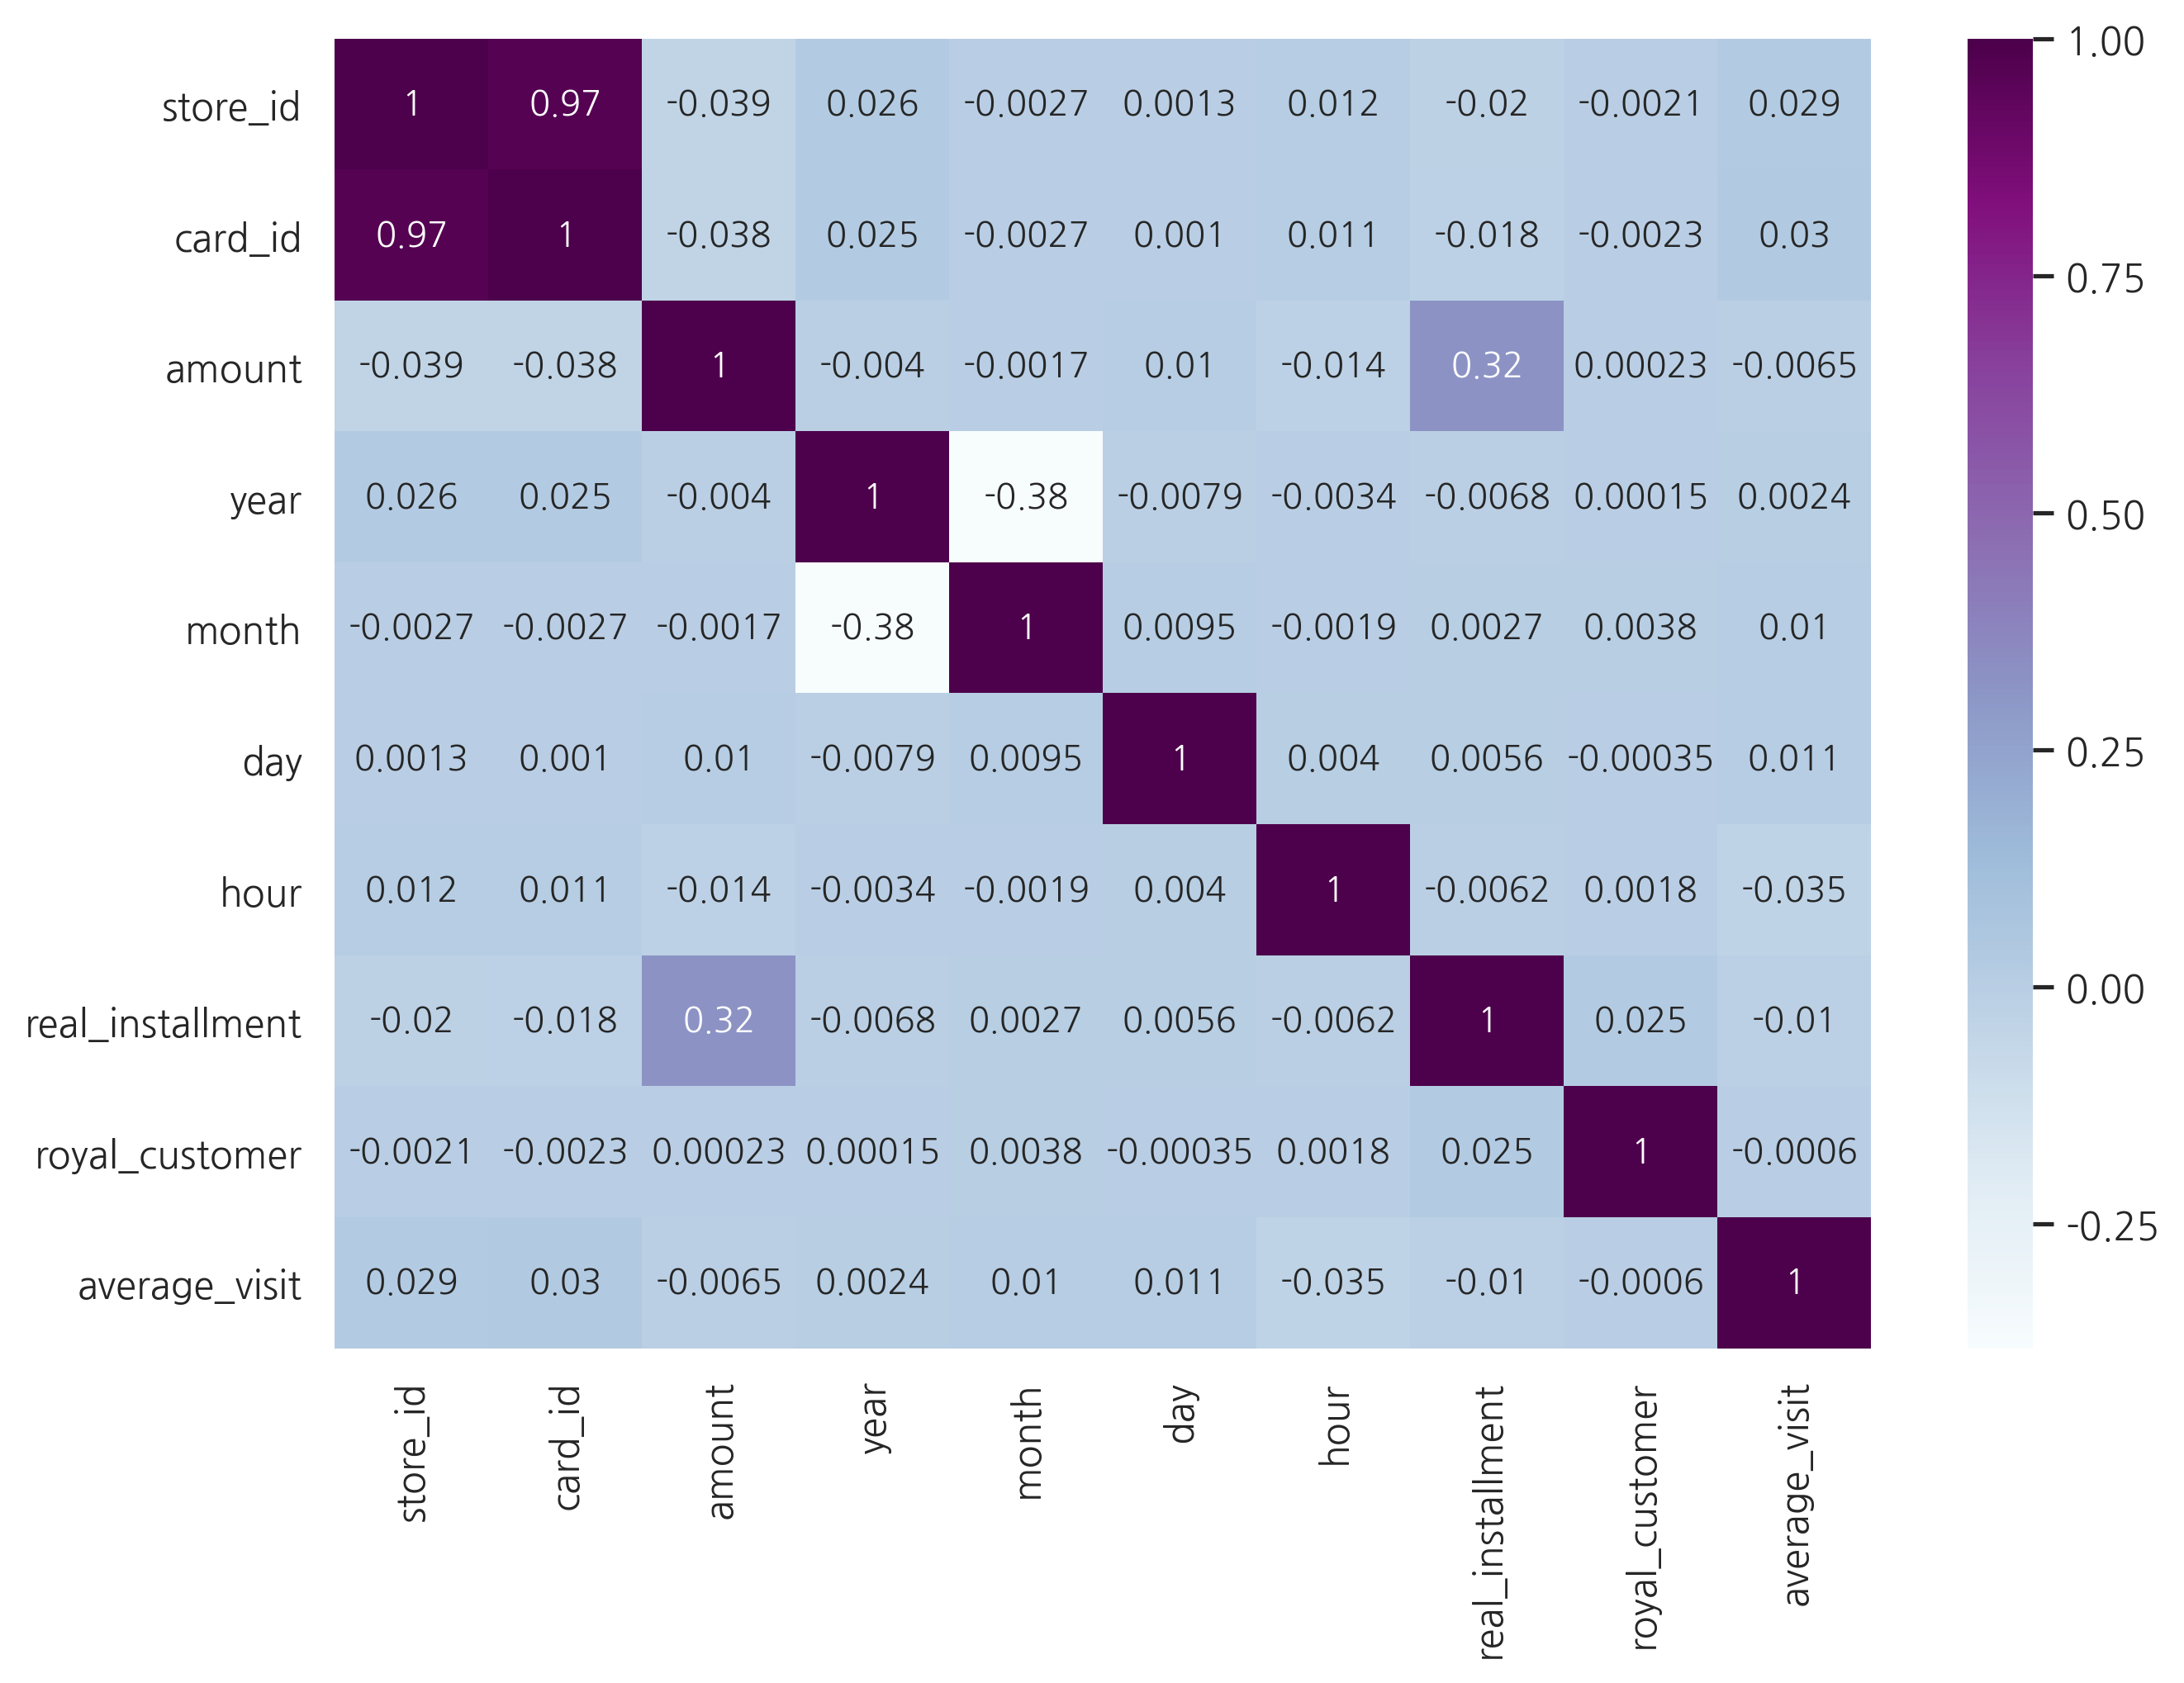

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(train.corr(), cmap='BuPu', annot=True)

- real_installment와 amount의 상관관계가 0.32로 조금 높아졌다
- royal_customer와 average_visit는 amount와 상관관계가 거의 없다 